# Text Classification using TFIDF - H2O AutoML - Sklearn

In [112]:
# Generic Imports
import os
import sys
import time
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',1)
InteractiveShell.ast_node_interactivity = "all"

print(f"Time: {time.ctime()}, {time.tzname}")
print(f"Py Version: {sys.version}")
print(f"Py Executable: {sys.executable}")
print(f"Operation Sys: {sys.platform}")
print(f"Working Directory: {os.getcwd()}")
print(f"Numpy: {np.__version__}, Pandas: {pd.__version__}, Sklearn: {sklearn.__version__}")

def df_info_func(df, vizualize=False, threshold=3, display_sample=True, sample_count = 5,side_by_side=True):
    def f1(series):
        try: return str(series.unique().tolist())
        except: return '--'

    print(f'Rows: {df.shape[0]} N Cols: {df.shape[1]}')

    if df.shape[0] > 0:
        df_info = pd.DataFrame(index=df.columns)
        df_info['data_types'] = df.dtypes.values
        df_info['n_missing'] = df.isna().sum().values    
        df_info['missing_pct'] = round((df_info['n_missing'] / len(df))*100,2)

        df_ = df.astype(str).copy()

        df_info['n_unique'] = df_.apply(lambda x: x.nunique(),axis=0).values
        df_info['uniq_vals'] = df_.apply(lambda x: np.where(x.nunique() <= threshold, f1(x), '--')).values

        for c in df.columns:            
            if df[c].dtype == 'datetime64[ns]':
                dt_str = "From: " + df[c].min().strftime('%d-%b-%Y')
                dt_str += " Till: " + df[c].max().strftime('%d-%b-%Y')
                df_info.loc[c,'uniq_vals'] = dt_str                
            elif df[c].dtype == 'float64' or  df[c].dtype == 'int64':
                real_num_series = df[c].dropna()
                if len(real_num_series) > 0:
                    dt_str = "Min: " + str(int(real_num_series.min()))
                    dt_str += " Max: " + str(int(real_num_series.max()))
                    dt_str += " Mean: " + str(int(real_num_series.mean()))
                    dt_str += " Med: " + str(int(real_num_series.median()))
                    dt_str += " Std: " + str(int(real_num_series.std()))
                else:
                    dt_str = ""
                df_info.loc[c,'uniq_vals'] = dt_str
            else:
                pass
                
        df_info.reset_index(inplace=True)
        df_info.rename(columns={'index':'cols'},inplace=True)
        if vizualize:
            # import seaborn as sns
            # sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
            # or an another package to display missing values graph
            import missingno as msno 
            msno.matrix(df)

        sample_df = pd.concat([df.head(sample_count),df.tail(sample_count)])

        if side_by_side:
            from IPython.display import display_html
            space = "\xa0" * 10
            info_styler = df_info.style.set_table_attributes("style='display:inline'").set_caption('DF Info')
            df_styler = sample_df.style.set_table_attributes("style='display:inline'").set_caption('DF')
            display_html(info_styler._repr_html_() + space + df_styler._repr_html_(),raw=True)            
        else:
            from IPython.core.display import HTML
            display(HTML(df_info.to_html()))
            if display_sample:
                display(HTML(sample_df.to_html()))            
    else:
        print("Empty DataFrame")

Time: Fri Dec 17 19:51:28 2021, ('India Standard Time', 'India Summer Time')
Py Version: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Py Executable: C:\Users\Dakshayani\.conda\envs\atlantis_anaconda_venv\python.exe
Operation Sys: win32
Working Directory: G:\DataScience Learning\AI Engineering
Numpy: 1.19.2, Pandas: 1.1.5, Sklearn: 0.23.2


In [113]:
# Java needs to be installed in order for successful execution of AutoML package - "H2O"

# Verify Java version for "H20" module
!java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment Corretto-8.292.10.1 (build 1.8.0_292-b10)
OpenJDK 64-Bit Server VM Corretto-8.292.10.1 (build 25.292-b10, mixed mode)


In [107]:
# Other Imports
import re 

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Download the nltk corpus "punkt"
# Used for sentence tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dakshayani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [115]:
df = pd.read_csv("data/consumer_compliants.zip",compression='zip', sep= ',', quotechar='"')
df_info_func(df, sample_count=1)

Rows: 57453 N Cols: 18


,cols,data_types,n_missing,missing_pct,n_unique,uniq_vals
0,Date received,object,0,0.000000,354,--
1,Product,object,0,0.000000,6,--
2,Sub-product,object,0,0.000000,32,--
3,Issue,object,0,0.000000,44,--
4,Sub-issue,object,0,0.000000,160,--
5,Consumer complaint narrative,object,0,0.000000,55390,--
6,Company public response,object,0,0.000000,11,--
7,Company,object,0,0.000000,2197,--
8,State,object,0,0.000000,60,--
9,ZIP code,object,0,0.000000,2874,--


### OBJECTIVE:

Based on "Consumer Complaint Narrative", can we classfiy into what "Product" is belongs to.

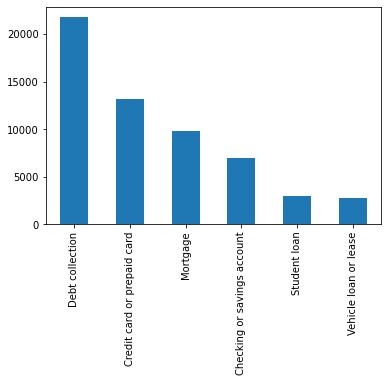

In [116]:
# Distribution of Product classes
df['Product'].value_counts().plot(kind='bar');

In [118]:
# Distribution of Company/Bank Details
df['Company'].value_counts()[:10]

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
SYNCHRONY FINANCIAL                      1584
AMERICAN EXPRESS COMPANY                 1217
Navient Solutions, LLC.                  1215
U.S. BANCORP                             954 
PORTFOLIO RECOVERY ASSOCIATES INC        922 
Name: Company, dtype: int64

In [122]:
# Create a Separate subset of Dataset
consumer_df = df[['Consumer complaint narrative','Company','Product']]
consumer_df.rename(columns={'Consumer complaint narrative':'Complaint'},inplace=True)
df_info_func(consumer_df,sample_count=1)

Rows: 57453 N Cols: 3


DF Info cols data_types n_missing missing_pct n_unique uniq_vals 
 
 0 
 Complaint 
 object 
 0 
 0.000000 
 55390 
 -- 
 
 
 1 
 Company 
 object 
 0 
 0.000000 
 2197 
 -- 
 
 
 2 
 Product 
 object 
 0 
 0.000000 
 6 
 -- 
 
            DF Complaint Company Product 
 
 0 
 This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account. 
 TRUIST FINANCIAL CORPORATION 
 Vehicle loan or lease 
 
 
 57452 
 I spoken with them several times in a year. An in XXXX they informed me yes they sold my information to a third party without my knowledge. Also, I told them that I dont owe them anything because my car was paid off by insurance XXXX an Gap an they said no. I also informed them that constantly calling me an telling me that my credit score would be damage was inappropriate. But on my credit they written several negative things. An I didnt give Exeter financial Corp no authority to sell my information to XXXX XXXX 
 Exeter Finance Corp. 
 Debt collection

In [121]:
# An Other Version of "Label Encoding"
# Out Target Variable here is "Product", 
# Here we are creating a Mapping to convert that category into a integer 

tgt_mapping = {v:idx for idx,v in enumerate(consumer_df.Product.unique())}
tgt_mapping

{'Checking or savings account': 2,
 'Credit card or prepaid card': 4,
 'Debt collection': 1,
 'Mortgage': 3,
 'Student loan': 5,
 'Vehicle loan or lease': 0}

In [123]:
# Creating a new column named "target", with Integer labels.
consumer_df['target'] = consumer_df['Product'].map(tgt_mapping)
consumer_df.head(1)

,Complaint,Company,Product,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",TRUIST FINANCIAL CORPORATION,Vehicle loan or lease,0


In [126]:
# Data Split to Train & Test
# 80-20 ratio of Training and Testing set respectively
X_train, X_test = train_test_split(consumer_df, test_size=0.2, random_state=111)
print(consumer_df.shape, X_train.shape, X_test.shape)

(57453, 4) (45962, 4) (11491, 4)


In [129]:
# Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

# We can use any kind of Stemmer for english with below 2 options.
# Port Stemmer and SnowballStemmer

# stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [136]:
# Examples of Stemming
stemmer.stem("beautiful")
stemmer.stem("working")
stemmer.stem("Learning")

'beauti'

'work'

'learn'

In [141]:
# Download Corpus for Stop Words from NLTK

nltk.download('stopwords')
stop_words = list(set(nltk.corpus.stopwords.words('english')))

# Sample Stopwords
stop_words[:10]

['about',
 'should',
 'where',
 "isn't",
 'hadn',
 'other',
 'further',
 've',
 'a',
 'same']

In [131]:
# Example of Tokenization
nltk.word_tokenize("Hello World , This is Natural Language!")

['Hello', 'World', ',', 'This', 'is', 'Natural', 'Language', '!']

In [166]:
# A Test Cleaning/Preparation Function
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+','', word.strip('Xx/'))))]
    tokens = map(str.lower, tokens)
    tokens = [re.sub("\d+","", item) for item in tokens]
    tokens = [re.sub("[^\w]*","", item) for item in tokens]
    tokens = [re.sub("\s+"," ", item) for item in tokens]
    stems = [stemmer.stem(item) for item in tokens if (item.strip() and(item not in stop_words))]
    return stems
tokenize("Apple 154.-  asking thinking sdsdnikp s32e8dwhiczxkc asbs@fidpsnd.com")

['appl', 'ask', 'think', 'sdsdnikp', 'sedwhiczxkc', 'asb', 'fidpsndcom']

In [139]:
# consumer_df['Complaint_Clean'] = consumer_df['Complaint'].apply(lambda x: tokenize(x))
# consumer_df.head(1)

In [165]:
# Building a TFIDF Vectorizer
top_n_words = 1000
frequency_of_word_in_document = 0.75

# Define the TFIDF Object
vectorizer_df = TfidfVectorizer(tokenizer=tokenize,
                                stop_words=None,
                                max_df = frequency_of_word_in_document,
                                max_features=top_n_words,
                                lowercase=False,
                                ngram_range=(1,2))

# Fit it on the data corpus
train_vectors = vectorizer_df.fit_transform(X_train.Complaint)

# Check the resulting Shape
# There should be "top_n_words" number of columns in the resulting dataset
train_vectors.shape

(45962, 1000)

In [167]:
train_vectors.A.shape

(45962, 1000)

In [179]:
print(vectorizer_df.get_feature_names()[:10])
print(vectorizer_df.get_feature_names()[-10:])

['abil', 'abl', 'absolut', 'abus', 'accept', 'access', 'access account', 'accord', 'account', 'account account']
['would call', 'would like', 'would need', 'would receiv', 'would take', 'write', 'written', 'wrong', 'wrote', 'year']


In [187]:
test_vectors = vectorizer_df.transform(X_test.Complaint)
test_vectors.shape

(11491, 1000)

In [183]:
train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer_df.get_feature_names())
train_df = pd.concat([train_df, X_train['target'].reset_index(drop=True)], axis=1)
train_df.shape
train_df.head(1)

(45962, 1001)

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,agent,agre,agreement,alert,alleg,alleg debt,alli,allow,almost,along,alreadi,also,although,alway,america,american,american express,amex,amount,amount owe,andor,annual,anoth,answer,anyon,anyth,apart,appar,appeal,appear,appli,applic,apprais,appreci,approv,approxim,around,arrang,arriv,ask,assess,assign,assist,associ,assum,assur,attach,attempt,attempt collect,attorney,author,auto,...,think,third,third parti,though,thought,threaten,three,thus,ticket,time,time call,titl,today,told,told could,told would,took,total,toward,track,trade,transact,transfer,travel,treat,tri,tri collect,true,trust,turn,twice,type,unabl,unauthor,understand,unemploy,unfair,unfortun,union,unit,unless,updat,upon,us,usaa,use,util,valid,valid debt,valu,vehicl,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029631,0.0,0.0,0.0,0.02671,0.025379,0.0,0.0,0.0,0.0,0.0,0.029251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076221,0.0,0.0,0.0,0.0,0.0,0.0,0.057988,0.0,0.0,0.0,0.0236,0.0,0.033903,0.0,0.0,0.0,0.0,0.032711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071833,0.0,0.195931,0.0,0.095547,0.029959,0.0,...,0.0,0.035198,0.041164,0.0,0.0,0.0,0.029438,0.0,0.0,0.030658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291988,0.362326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [185]:
test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer_df.get_feature_names())
test_df=pd.concat([test_df, X_test['target'].reset_index(drop=True)], axis=1)
test_df.shape
test_df.head(1)

(11491, 1001)

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,agent,agre,agreement,alert,alleg,alleg debt,alli,allow,almost,along,alreadi,also,although,alway,america,american,american express,amex,amount,amount owe,andor,annual,anoth,answer,anyon,anyth,apart,appar,appeal,appear,appli,applic,apprais,appreci,approv,approxim,around,arrang,arriv,ask,assess,assign,assist,associ,assum,assur,attach,attempt,attempt collect,attorney,author,auto,...,think,third,third parti,though,thought,threaten,three,thus,ticket,time,time call,titl,today,told,told could,told would,took,total,toward,track,trade,transact,transfer,travel,treat,tri,tri collect,true,trust,turn,twice,type,unabl,unauthor,understand,unemploy,unfair,unfortun,union,unit,unless,updat,upon,us,usaa,use,util,valid,valid debt,valu,vehicl,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.086996,0.0,0.0,0.0,0.212102,0.0,0.0,0.348282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041372,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.101118,0.0,0.0,0.0,0.0,0.0,0.051789,0.0,0.0,0.0,0.089659,0.0,0.110516,0.0,0.09441,0.0,0.0,0.0,0.0,0.17992,0.072403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043197,0.0,0.0,0.0,0.085811,0.0,0.0,0.0,0.0,0.078427,0.0,0.0,0.0,0.0,0.0,0.0,0.10988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [205]:
# variable Names

x_variable_names = vectorizer_df.get_feature_names()
y_variable_names = 'target'

## Auto ML Model - H20

In [228]:
import h2o
from h2o.automl import H2OAutoML

In [227]:
# Shut down any h2o Instance if already open
h2o.shutdown()

# Initialize H20 instance 
h2o.init()

# Converting the Data Frame to a H2O like Dataframe
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

# Convert the target variable into a Factor
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

# Define an AutoML Object
auto_ml = H2OAutoML(max_models=5,
                    seed = 10,
                    exclude_algos=['StackedEnsemble'],
                    verbosity="info",
                    nfolds=0,
                    balance_classes=True,
                    max_after_balance_size=0.3)

# Training
auto_ml.train(x = x_variable_names, y = y_variable_names, training_frame = h2o_train_df, validation_frame = h2o_test_df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Corretto-8.292.10.1 (build 25.292-b10, mixed mode)
  Starting server from C:\Users\Dakshayani\.conda\envs\atlantis_anaconda_venv\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DAKSHA~1\AppData\Local\Temp\tmph25dydya
  JVM stdout: C:\Users\DAKSHA~1\AppData\Local\Temp\tmph25dydya\h2o_Dakshayani_started_from_python.out
  JVM stderr: C:\Users\DAKSHA~1\AppData\Local\Temp\tmph25dydya\h2o_Dakshayani_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,5 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_Dakshayani_zy82n0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
22:33:04.648: Project: AutoML_20211217_223304646
22:33:04.649: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:33:04.653: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
22:33:04.653: Build control seed: 10
22:33:04.654: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
22:33:06.20: training frame: Frame key: automl_training_py_145_sid_bee6    cols: 1001    rows: 41256  chunks: 53    size: 34389308  checksum: 7047915290339016214
22:33:06.23: validation frame: Frame key: py_146_sid_bee6    cols: 1001    rows: 11491  chunks: 14    size: 9664559  checksum: -1782142495578309477
22:33:06.48: leaderboard frame: Frame key: automl_leaderboa

In [229]:
auto_ml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
GBM_3_AutoML_20211217_223304,0.164077,0.408785,0.346087,0.119776,nan,nan
GBM_2_AutoML_20211217_223304,0.169834,0.409924,0.349448,0.122114,nan,nan
GLM_1_AutoML_20211217_223304,0.173743,0.376236,0.336408,0.113171,nan,nan
GBM_1_AutoML_20211217_223304,0.178452,0.424514,0.354916,0.125966,nan,nan
DRF_1_AutoML_20211217_223304,0.286641,0.599026,0.447034,0.199839,nan,nan


In [233]:
# The predictions p0, p1, p2,.. , p5 are 
# predictions for each of the 6 classes 
# The "predict" column is the label of class that is predicted
predictions = auto_ml.leader.predict(h2o_test_df)
predictions

predict,p0,p1,p2,p3,p4,p5
2,8.88222e-05,0.000800604,0.998111,0.000195195,0.000757641,4.65183e-05
3,0.000678095,0.0157505,0.0011452,0.977349,0.00471963,0.00035713
4,0.00139014,0.0184695,0.00274738,0.00107035,0.975849,0.000473718
5,0.000688339,0.00448308,0.000395436,0.00227324,0.00125209,0.990908
4,0.00125613,0.00650997,0.00118784,0.00118532,0.989442,0.000419229
0,0.982997,0.00762033,0.00278873,0.00096872,0.00527923,0.000345588
0,0.811686,0.0289553,0.00784905,0.104878,0.0111383,0.0354929
3,0.000676213,0.00188774,0.000447088,0.988916,0.00778727,0.000285991
1,0.0622506,0.66503,0.0175405,0.0547345,0.189531,0.0109133
1,0.0694203,0.461624,0.270237,0.0445738,0.122144,0.0320011


In [234]:
# Confusion Matrix
# Rows: Actuals, Cols: Predictions
# Error: (total error) / (total records in class)
# Rate: (total errors) / (total records in class)

auto_ml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.1147006829976299
RMSE: 0.3386748927771734
LogLoss: 0.38604534945422914
Mean Per-Class Error: 0.16079294278028852
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,363.0,106.0,8.0,17.0,29.0,3.0,0.309886,163 / 526
1,66.0,3884.0,42.0,68.0,179.0,56.0,0.095693,"411 / 4,295"
2,4.0,58.0,1265.0,15.0,115.0,4.0,0.134155,"196 / 1,461"
3,34.0,99.0,23.0,1817.0,25.0,17.0,0.098263,"198 / 2,015"
4,31.0,200.0,119.0,24.0,2204.0,5.0,0.146729,"379 / 2,583"
5,22.0,52.0,4.0,11.0,21.0,501.0,0.180033,110 / 611
6,520.0,4399.0,1461.0,1952.0,2573.0,586.0,0.126795,"1,457 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.873205
1,2,0.954921
2,3,0.979201
3,4,0.990949
4,5,0.996519
5,6,1.000000


In [240]:
model_ids = list(auto_ml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model(model_ids[0])
out

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20211217_223304


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,135.0,810.0,362785.0,8.0,8.0,8.0,9.0,93.0,30.459259




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.04948010759759144
RMSE: 0.22244124527072634
LogLoss: 0.17008483677516914
Mean Per-Class Error: 0.041220102452112384
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,1784.0,201.0,3.0,9.0,58.0,3.0,0.133139,"274 / 2,058"
1,3.0,2075.0,0.0,1.0,4.0,0.0,0.003841,"8 / 2,083"
2,0.0,22.0,2031.0,0.0,7.0,0.0,0.014078,"29 / 2,060"
3,1.0,9.0,0.0,2046.0,11.0,0.0,0.010160,"21 / 2,067"
4,1.0,38.0,1.0,1.0,2022.0,2.0,0.020823,"43 / 2,065"
5,3.0,84.0,1.0,8.0,39.0,1933.0,0.065280,"135 / 2,068"
6,1792.0,2429.0,2036.0,2065.0,2141.0,1938.0,0.041126,"510 / 12,401"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.958874
1,2,0.989436
2,3,0.996694
3,4,0.998871
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.1147006829976299
RMSE: 0.3386748927771734
LogLoss: 0.38604534945422914
Mean Per-Class Error: 0.16079294278028852
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,363.0,106.0,8.0,17.0,29.0,3.0,0.309886,163 / 526
1,66.0,3884.0,42.0,68.0,179.0,56.0,0.095693,"411 / 4,295"
2,4.0,58.0,1265.0,15.0,115.0,4.0,0.134155,"196 / 1,461"
3,34.0,99.0,23.0,1817.0,25.0,17.0,0.098263,"198 / 2,015"
4,31.0,200.0,119.0,24.0,2204.0,5.0,0.146729,"379 / 2,583"
5,22.0,52.0,4.0,11.0,21.0,501.0,0.180033,110 / 611
6,520.0,4399.0,1461.0,1952.0,2573.0,586.0,0.126795,"1,457 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.873205
1,2,0.954921
2,3,0.979201
3,4,0.990949
4,5,0.996519
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-12-17 22:48:01,0.000 sec,0.0,0.840796,2.052271,0.832030,NaN,NaN,0.765318,1.568470,0.626229,NaN,NaN
1,,2021-12-17 22:48:24,22.179 sec,5.0,0.655527,1.181469,0.452383,NaN,NaN,0.563223,0.882501,0.256375,NaN,NaN
2,,2021-12-17 22:48:43,41.302 sec,10.0,0.544557,0.858978,0.226837,NaN,NaN,0.474188,0.668683,0.179967,NaN,NaN
3,,2021-12-17 22:49:00,58.673 sec,15.0,0.470328,0.678613,0.178776,NaN,NaN,0.426195,0.561813,0.164825,NaN,NaN
4,,2021-12-17 22:49:17,1 min 15.422 sec,20.0,0.423838,0.569570,0.156842,NaN,NaN,0.400842,0.505328,0.157602,NaN,NaN
5,,2021-12-17 22:49:33,1 min 32.122 sec,25.0,0.392199,0.495738,0.144021,NaN,NaN,0.385461,0.471108,0.150292,NaN,NaN
6,,2021-12-17 22:49:49,1 min 47.666 sec,30.0,0.368935,0.441567,0.132167,NaN,NaN,0.374861,0.448049,0.145331,NaN,NaN
7,,2021-12-17 22:50:04,2 min 2.659 sec,35.0,0.351144,0.400456,0.120716,NaN,NaN,0.368192,0.434138,0.142633,NaN,NaN
8,,2021-12-17 22:50:19,2 min 17.408 sec,40.0,0.336806,0.368679,0.109749,NaN,NaN,0.363019,0.423561,0.137934,NaN,NaN
9,,2021-12-17 22:50:34,2 min 32.508 sec,45.0,0.323510,0.341495,0.100395,NaN,NaN,0.358619,0.414976,0.135845,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,4208.062500,1.000000,0.115866
1,card,2849.077881,0.677052,0.078447
2,student,2187.399414,0.519812,0.060228
3,vehicl,1946.655273,0.462601,0.053600
4,loan,1804.696533,0.428866,0.049691
5,debt,1761.290649,0.418551,0.048496
6,bank,1470.135864,0.349362,0.040479
7,collect,1455.981445,0.345998,0.040089
8,student loan,980.148376,0.232922,0.026988
9,deposit,973.881836,0.231432,0.026815



See the whole table with table.as_data_frame()


## Predictions Using SkLearn

### Gradient Boosting Model

In [241]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [242]:
# GBM Model Fit & Train
gbm_clf = GradientBoostingClassifier()
gbm_clf.fit(train_vectors, X_train['target'])

GradientBoostingClassifier()

In [243]:
# Making predictions of GBM 
predictions = gbm_clf.predict(test_vectors)

# Confusion matrix to evaluate results
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[ 321  111   16   27   48    3]
 [  53 3952   29   66  152   43]
 [  10   78 1217   13  142    1]
 [  25  103   27 1825   24   11]
 [  14  262   87   13 2205    2]
 [  18   72    2   36   25  458]]


In [244]:
print(classification_report(X_test['target'], predictions))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       526
           1       0.86      0.92      0.89      4295
           2       0.88      0.83      0.86      1461
           3       0.92      0.91      0.91      2015
           4       0.85      0.85      0.85      2583
           5       0.88      0.75      0.81       611

    accuracy                           0.87     11491
   macro avg       0.85      0.81      0.83     11491
weighted avg       0.87      0.87      0.87     11491



In [245]:
# In Order to Improve the accuracy of low frequency classes
# Imporve the weightage of each class

In [246]:
from sklearn.utils import class_weight

In [248]:
# Takes argument the weightage type, unique class labels, series of values
print(np.unique(X_train['target']))
cwts = class_weight.compute_class_weight('balanced', np.unique(X_train['target']), X_train['target'])
cwts = list(cwts)
print(cwts)

[0 1 2 3 4 5]
[3.466214177978884, 0.43830939711239536, 1.382232647660291, 0.9841127098321343, 0.7219918316054037, 3.275046316089497]


In [249]:
# A dummy array of weights
weights = np.ones(X_train.shape[0], dtype='float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [252]:
print(X_train['target'][:5].values)
for i, val in enumerate(X_train['target']):
    weights[i] = cwts[val]
print(weights[:5])

[2 1 1 4 2]
[1.38223265 0.4383094  0.4383094  0.72199183 1.38223265]


In [253]:
# Fitting the imbalenced classes with weights
gbm_clf = GradientBoostingClassifier()
gbm_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

GradientBoostingClassifier()

In [254]:
print("Accuracy Score (test): {0:.3f}".format(gbm_clf.score(test_vectors, X_test['target'])))

Accuracy Score (test): 0.857


In [255]:
predictions = gbm_clf.predict(test_vectors)
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[ 438   37   14    7   18   12]
 [ 193 3648   93   94  189   78]
 [  22   23 1306   12   93    5]
 [  96   35   32 1805   13   34]
 [ 116  149  164   20 2129    5]
 [  56   22    2    7    5  519]]


In [256]:
print(classification_report(X_test['target'], predictions))

              precision    recall  f1-score   support

           0       0.48      0.83      0.61       526
           1       0.93      0.85      0.89      4295
           2       0.81      0.89      0.85      1461
           3       0.93      0.90      0.91      2015
           4       0.87      0.82      0.85      2583
           5       0.79      0.85      0.82       611

    accuracy                           0.86     11491
   macro avg       0.80      0.86      0.82     11491
weighted avg       0.87      0.86      0.86     11491



In [266]:
# predictions
inverse_mapping = {v:k for k,v in tgt_mapping.items()}
actual_prediction_labels = [inverse_mapping[i] for i in predictions]

final_df = X_test.copy()
final_df['predicted_product'] = actual_prediction_labels
final_df = final_df[['Complaint', 'Product', 'predicted_product']]
final_df.head()

,Complaint,Product,predicted_product
30060,"I have a business checking account at BB & T. On XX/XX/2019, I att...",Checking or savings account,Checking or savings account
53473,"To who it may concern, My concern is regarding Shellpoint Mortgage...",Mortgage,Mortgage
35879,I contacted XXXX about fraudulent charges that were made on my acc...,Credit card or prepaid card,Credit card or prepaid card
20993,I first applied for the Fedloan Serving program in XXXX in hopes o...,Student loan,Student loan
53,On several occasions ( XXXX ) I have tried to reach someone in cos...,Credit card or prepaid card,Credit card or prepaid card
